In [1]:
#ALTERED FROM:https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
#READ METADATA FILE FOR TRAINING DATA
import pandas as pd
from pathlib import Path

# Read metadata file
metadata_file = r'/home2/qlpd78/crash-bang-wallop/data/data/metadata_2/METADATA_2.csv'
df = pd.read_csv(metadata_file)
df.head()

# Construct file path by concatenating fold and file name
df['relative_path'] = '/' + df['AUDIO'].astype(str)

# Take relevant columns
df = df[['relative_path', 'Y2']]
df.head()


,relative_path,Y2
0,/fold_2/Bright_Black_10.wav,9
1,/fold_2/Bright_Black_100.wav,7
2,/fold_2/Bright_Black_101.wav,7
3,/fold_2/Bright_Black_102.wav,7
4,/fold_2/Bright_Black_103.wav,7


In [2]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import numpy as np
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def confusion_matrix_func():
  y_pred = []
  y_true = []

# iterate over test data
  for data in val_dl:
    inputs, labels = data[0].to(device), data[1].to(device)
    inputs_m, inputs_s = inputs.mean(), inputs.std()
    inputs = (inputs - inputs_m) / inputs_s

    output = myModel(inputs) # Feed Networ

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
        
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth
#print(y_pred)
#print(y_true)
# constant for classes
  classes = ("St316", "St430", "St304", "En24", "BD2", "En3B", "En1A", "Black", "Galvanised", "Bright" )

# Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10 , index = [i for i in classes],
                      columns = [i for i in classes])
  fig=plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  run["train/confusion_matrix"].upload(fig)
  



class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)
#convert mono to stereo
   # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))
 # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))
 # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)
 # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)
  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)
  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [3]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'Y2']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    #aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return sgram, class_id

In [4]:
from torch.utils.data import random_split
from pathlib import Path
import os
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init

def inference (model, val_dl):
    correct_prediction = 0
    total_prediction = 0
    wrong=[]

  # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
            outputs = model(inputs)

      # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            cpu_prediction = prediction.cpu().numpy()
            cpu_labels = labels.cpu().numpy()
            for i in range(len(cpu_prediction)):
                if cpu_prediction[i]!=cpu_labels[i]:
                    wrong.append([cpu_prediction[i],cpu_labels[i]])
                    
      # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
    #print(wrong)
    acc = correct_prediction/total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')
    return acc,wrong



#add code to run inference on every epoch of the training?
data_path=r'/home2/qlpd78/crash-bang-wallop/data/data' #change user (krsd48) as needed
myds = SoundDS(df, data_path)


# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])
# Create training and validation data loaders
train_dl =torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)
print(num_train)
print(num_val)

1878
470


In [5]:



# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [6]:
import neptune.new as neptune
num_epochs=100

run = neptune.init(
    project="crshbng/Crash",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5YTdjYjc1OC0wMzliLTQwYzMtODRhZS05NDMzYTJjN2M0MmEifQ==",
)  # your credentials
params = {
    "Num. Readings": num_items,
    "Num. Types": 5,
    "Type of ML": 'CNN Classification',
    "n_epochs": num_epochs,
    "Optimizer": "Adam",
    "Batch Size": 16,
    "Kernal Size": (5,3,3,3),
    "Var":"mel_non-aug_cm_grades",
    "Owner": "Freya"
}

run["parameters"] = params

import datetime

# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    inf = inference(myModel, val_dl)
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}, Validation Accuracy: {inf[0]:.2f}')
    if epoch==0 or epoch==19 or epoch==49 or epoch==99 or epoch==199:
      confusion_matrix_func()

    run["train/epoch/loss"].log(avg_loss)
    run["train/epoch/accuracy"].log(acc)
    run["train/epoch/inference"].log(inf[0])

  print('Finished Training')
  
  run.stop()
  
training(myModel, train_dl, num_epochs)
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
torch.save(myModel.state_dict(), f'{date}_model.pt')

https://app.neptune.ai/crshbng/Crash/e/CRAS-30
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


/home2/qlpd78/anaconda3/lib/python3.9/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


Accuracy: 0.38, Total items: 470
Epoch: 0, Loss: 2.09, Accuracy: 0.34, Validation Accuracy: 0.38
Finished Training
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 13 operations to synchronize with Neptune. Do not kill this process.


All 13 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/crshbng/Crash/e/CRAS-30


In [7]:
def inference (model, val_dl):
    correct_prediction = 0
    total_prediction = 0
    wrong=[]

  # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
            outputs = model(inputs)

      # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            cpu_prediction = prediction.cpu().numpy()
            cpu_labels = labels.cpu().numpy()
            for i in range(len(cpu_prediction)):
                if cpu_prediction[i]!=cpu_labels[i]:
                    wrong.append([cpu_prediction[i],cpu_labels[i]])
                    
      # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
    #print(wrong)
    acc = correct_prediction/total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')
    return acc,wrong

# Run inference on trained model with the validation set
inference(myModel, val_dl)

#add code to run inference on every epoch of the training?

Accuracy: 0.37, Total items: 470


(0.3659574468085106,
 [[4, 0],
  [4, 1],
  [4, 0],
  [0, 1],
  [0, 1],
  [0, 1],
  [0, 3],
  [4, 0],
  [0, 1],
  [4, 1],
  [0, 2],
  [4, 0],
  [2, 0],
  [0, 4],
  [0, 3],
  [0, 3],
  [0, 3],
  [0, 2],
  [0, 1],
  [4, 0],
  [0, 1],
  [0, 1],
  [4, 2],
  [4, 2],
  [0, 3],
  [0, 1],
  [4, 1],
  [1, 4],
  [4, 1],
  [1, 3],
  [1, 0],
  [0, 3],
  [1, 0],
  [1, 0],
  [2, 0],
  [0, 1],
  [4, 3],
  [1, 3],
  [4, 0],
  [0, 1],
  [0, 4],
  [0, 3],
  [0, 3],
  [4, 2],
  [0, 1],
  [0, 1],
  [4, 0],
  [0, 1],
  [4, 0],
  [0, 3],
  [0, 1],
  [0, 3],
  [4, 0],
  [2, 4],
  [0, 3],
  [0, 3],
  [0, 1],
  [1, 3],
  [0, 4],
  [1, 3],
  [0, 3],
  [0, 3],
  [4, 3],
  [4, 0],
  [1, 0],
  [1, 0],
  [4, 0],
  [0, 1],
  [4, 2],
  [0, 3],
  [2, 1],
  [2, 0],
  [2, 4],
  [4, 0],
  [4, 2],
  [4, 0],
  [0, 1],
  [0, 2],
  [0, 1],
  [0, 3],
  [0, 3],
  [0, 1],
  [4, 3],
  [0, 2],
  [0, 1],
  [4, 2],
  [0, 2],
  [2, 4],
  [0, 3],
  [0, 1],
  [0, 4],
  [0, 1],
  [0, 3],
  [4, 2],
  [4, 2],
  [0, 3],
  [0, 1],
  [0, 3],

In [8]:
total = []
inc=[]
for i in range(10):
    val,wrong=inference(myModel, val_dl)
    total.append(val)
    inc.append(wrong)
   
    

Accuracy: 0.39, Total items: 470
Accuracy: 0.40, Total items: 470
Accuracy: 0.38, Total items: 470
Accuracy: 0.36, Total items: 470
Accuracy: 0.39, Total items: 470
Accuracy: 0.40, Total items: 470
Accuracy: 0.38, Total items: 470
Accuracy: 0.39, Total items: 470
Accuracy: 0.37, Total items: 470
Accuracy: 0.37, Total items: 470


In [9]:
print(f"{100*np.mean(total)} +/- {100*(np.std(total)/len(total))} %")

38.21276595744681 +/- 0.10773607575465677 %


/home2/qlpd78/anaconda3/lib/python3.9/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


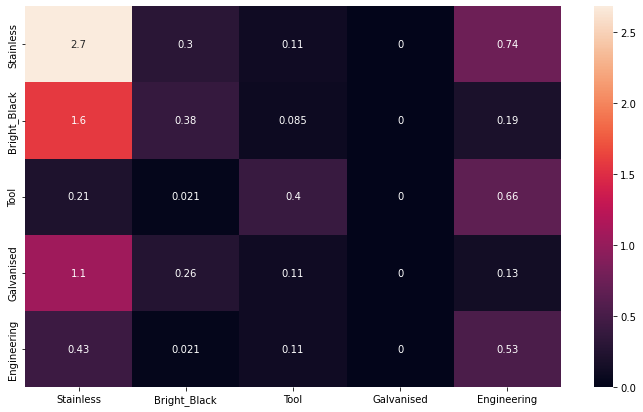

In [11]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def confusion_matrix():
  y_pred = []
  y_true = []

# iterate over test data
  for data in val_dl:
    inputs, labels = data[0].to(device), data[1].to(device)
    inputs_m, inputs_s = inputs.mean(), inputs.std()
    inputs = (inputs - inputs_m) / inputs_s

    output = myModel(inputs) # Feed Networ

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
        
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth
#print(y_pred)
#print(y_true)
# constant for classes
  classes = ('Stainless', 'Bright_Black', 'Tool', 'Galvanised', 'Engineering')

# Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10 , index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.show()


#print(cf_matrix)
print(confusion_matrix())